In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_csv('alipur,-delhi, delhi, india-air-quality.csv', parse_dates=['date'])  
df.index = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [3]:
numeric_columns = [' pm10', ' pm25', ' o3', ' no2', ' so2', ' co']
non_numeric_values = df[numeric_columns].apply(lambda x: pd.to_numeric(x, errors='coerce')).isnull().sum()

df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

In [4]:
df.ffill(inplace=True)

In [5]:
df.tail()

,pm25,pm10,o3,no2,so2,co
date,,,,,,
2024-01-23,339,181.0,53.0,21.0,13.0,5.0
2024-01-24,379,312.0,19.0,48.0,15.0,11.0
2024-01-25,366,71.0,35.0,21.0,13.0,2.0
2024-01-26,302,157.0,23.0,29.0,12.0,5.0
2024-01-27,232,157.0,32.0,6.0,5.0,14.0


In [6]:
for col in df.columns:
    
    # ADF test
    result = adfuller(df[col])  
    if result[1] > 0.05:
        print(f"{col} is non-stationary")
        
    else:
        print(f"{col} is stationary")

 pm25 is stationary
 pm10 is stationary
 o3 is stationary
 no2 is stationary
 so2 is stationary
 co is stationary


In [7]:
exog_cols = [' pm25', ' o3', ' no2', ' so2', ' co']
train_size = int(len(df) * 0.95)
train, test = df[:train_size], df[train_size:]

In [8]:
#??????????????????????
#scp = pm.auto_arima(train[' pm10'], seasonal=True, m=7, 
 #                   start_p=0, max_p=3, start_q=0, max_q=3,
  #                  start_P=0, max_P=3, start_Q=0, max_Q=3, 
   #                 start_d=0, max_d=3, D=1, max_D=3, 
    #                trace=True, error_action='ignore')

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=21225.281, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=19956.170, Time=0.96 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=19939.003, Time=1.49 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=21223.282, Time=0.04 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : AIC=20625.566, Time=0.30 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=inf, Time=2.58 sec
 ARIMA(0,0,1)(0,1,2)[7] intercept   : AIC=inf, Time=8.00 sec
 ARIMA(0,0,1)(1,1,0)[7] intercept   : AIC=20211.003, Time=0.67 sec
 ARIMA(0,0,1)(1,1,2)[7] intercept   : AIC=inf, Time=10.62 sec
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=20699.233, Time=0.89 sec
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=2.15 sec
 ARIMA(0,0,2)(0,1,1)[7] intercept   : AIC=inf, Time=2.84 sec
 ARIMA(1,0,0)(0,1,1)[7] intercept   : AIC=inf, Time=1.01 sec
 ARIMA(1,0,2)(0,1,1)[7] intercept   : AIC=inf, Time=2.37 sec
 ARIMA(0,0,1)(0,1,1)[7]             : AIC=19937.006, Time=0.

In [9]:
sarimax_model = SARIMAX(train[' pm10'], exog=train[exog_cols], order=(0, 0, 1), seasonal_order=(0, 1, 1, 7), trend='ct')
sarimax_results = sarimax_model.fit(disp=False)

/home/aks/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/aks/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [682]:
#sarimax_model = SARIMAX(seasonal, exog=train[exog_cols], order=(2, 0, 1), seasonal_order=(3, 1, 0, 7))
#sarimax_seasonal_results = sarimax_model.fit(disp=False)

In [10]:
sarimax_pred = sarimax_results.get_forecast(steps=len(test), exog=test[exog_cols])
#sarimax_seasonal_pred = sarimax_seasonal_results.get_forecast(steps=len(test), exog=test[exog_cols])

/home/aks/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [11]:
#trend_pred = sarimax_trend_pred.predicted_mean
#seasonal_pred = sarimax_seasonal_pred.predicted_mean

sarimax_pred_mean = sarimax_pred.predicted_mean


In [12]:
sarimax_pred_mean.index

RangeIndex(start=1781, stop=1875, step=1)

In [13]:
sarimax_pred_mean.index = test.index

In [14]:
test.index

DatetimeIndex(['2023-10-26', '2023-10-27', '2023-10-28', '2023-10-29',
               '2023-10-30', '2023-10-31', '2023-11-01', '2023-11-02',
               '2023-11-03', '2023-11-04', '2023-11-05', '2023-11-06',
               '2023-11-07', '2023-11-08', '2023-11-09', '2023-11-10',
               '2023-11-11', '2023-11-12', '2023-11-13', '2023-11-14',
               '2023-11-15', '2023-11-16', '2023-11-17', '2023-11-18',
               '2023-11-19', '2023-11-20', '2023-11-21', '2023-11-22',
               '2023-11-23', '2023-11-24', '2023-11-25', '2023-11-26',
               '2023-11-27', '2023-11-28', '2023-11-29', '2023-11-30',
               '2023-12-01', '2023-12-02', '2023-12-03', '2023-12-04',
               '2023-12-05', '2023-12-06', '2023-12-07', '2023-12-08',
               '2023-12-09', '2023-12-10', '2023-12-11', '2023-12-12',
               '2023-12-13', '2023-12-14', '2023-12-15', '2023-12-16',
               '2023-12-17', '2023-12-18', '2023-12-19', '2023-12-20',
      

In [15]:
sarimax_pred_mean.index

DatetimeIndex(['2023-10-26', '2023-10-27', '2023-10-28', '2023-10-29',
               '2023-10-30', '2023-10-31', '2023-11-01', '2023-11-02',
               '2023-11-03', '2023-11-04', '2023-11-05', '2023-11-06',
               '2023-11-07', '2023-11-08', '2023-11-09', '2023-11-10',
               '2023-11-11', '2023-11-12', '2023-11-13', '2023-11-14',
               '2023-11-15', '2023-11-16', '2023-11-17', '2023-11-18',
               '2023-11-19', '2023-11-20', '2023-11-21', '2023-11-22',
               '2023-11-23', '2023-11-24', '2023-11-25', '2023-11-26',
               '2023-11-27', '2023-11-28', '2023-11-29', '2023-11-30',
               '2023-12-01', '2023-12-02', '2023-12-03', '2023-12-04',
               '2023-12-05', '2023-12-06', '2023-12-07', '2023-12-08',
               '2023-12-09', '2023-12-10', '2023-12-11', '2023-12-12',
               '2023-12-13', '2023-12-14', '2023-12-15', '2023-12-16',
               '2023-12-17', '2023-12-18', '2023-12-19', '2023-12-20',
      

In [16]:
sarimax_pred_hourly = np.repeat(sarimax_pred_mean.values, 24)

In [17]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(sarimax_pred_hourly.reshape(-1, 1))

In [18]:
sequence_length = 10
x, y = [], []
for i in range(len(scaled_data) - sequence_length):
    x.append(scaled_data[i:(i + sequence_length)])
    y.append(scaled_data[i + sequence_length])

x, y = np.array(x), np.array(y)

In [19]:
x = np.reshape(x, (x.shape[0], x.shape[1], 1))

In [20]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(x.shape[1], 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(units=1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(x, y, epochs=17, batch_size=32)

Epoch 1/17
71/71 [==============================] - 3s 10ms/step - loss: 0.0331
Epoch 2/17
71/71 [==============================] - 1s 9ms/step - loss: 0.0062
Epoch 3/17
71/71 [==============================] - 1s 9ms/step - loss: 0.0057
Epoch 4/17
71/71 [==============================] - 1s 9ms/step - loss: 0.0053
Epoch 5/17
71/71 [==============================] - 1s 9ms/step - loss: 0.0047
Epoch 6/17
71/71 [==============================] - 1s 9ms/step - loss: 0.0039
Epoch 7/17
71/71 [==============================] - 1s 9ms/step - loss: 0.0039
Epoch 8/17
71/71 [==============================] - 1s 9ms/step - loss: 0.0031
Epoch 9/17
71/71 [==============================] - 1s 9ms/step - loss: 0.0030
Epoch 10/17
71/71 [==============================] - 1s 9ms/step - loss: 0.0028
Epoch 11/17
71/71 [==============================] - 1s 9ms/step - loss: 0.0027
Epoch 12/17
71/71 [==============================] - 1s 10ms/step - loss: 0.0026
Epoch 13/17
71/71 [============================

In [21]:
future_hours = 12  # Number of hours to predict
input_sequence = scaled_data[-sequence_length:].reshape(1, -1, 1)

In [22]:
lstm_preds = []
for _ in range(future_hours):
    lstm_pred = lstm_model.predict(input_sequence)
    lstm_preds.append(lstm_pred[0, 0])
    input_sequence = np.append(input_sequence[:, 1:, :], lstm_pred.reshape(1, 1, 1), axis=1)

1/1 [==============================] - 0s 16ms/step


In [23]:
lstm_preds = scaler.inverse_transform(np.array(lstm_preds).reshape(-1, 1))

In [24]:
lstm_preds

array([[18.31007 ],
       [19.209427],
       [20.421219],
       [21.733408],
       [23.062458],
       [24.376362],
       [25.664629],
       [26.926367],
       [28.165215],
       [29.386961],
       [30.598152],
       [31.788317]], dtype=float32)

In [25]:
test.index

DatetimeIndex(['2023-10-26', '2023-10-27', '2023-10-28', '2023-10-29',
               '2023-10-30', '2023-10-31', '2023-11-01', '2023-11-02',
               '2023-11-03', '2023-11-04', '2023-11-05', '2023-11-06',
               '2023-11-07', '2023-11-08', '2023-11-09', '2023-11-10',
               '2023-11-11', '2023-11-12', '2023-11-13', '2023-11-14',
               '2023-11-15', '2023-11-16', '2023-11-17', '2023-11-18',
               '2023-11-19', '2023-11-20', '2023-11-21', '2023-11-22',
               '2023-11-23', '2023-11-24', '2023-11-25', '2023-11-26',
               '2023-11-27', '2023-11-28', '2023-11-29', '2023-11-30',
               '2023-12-01', '2023-12-02', '2023-12-03', '2023-12-04',
               '2023-12-05', '2023-12-06', '2023-12-07', '2023-12-08',
               '2023-12-09', '2023-12-10', '2023-12-11', '2023-12-12',
               '2023-12-13', '2023-12-14', '2023-12-15', '2023-12-16',
               '2023-12-17', '2023-12-18', '2023-12-19', '2023-12-20',
      

In [26]:
pd.DataFrame(lstm_preds, pd.date_range(start=test.index.max(), periods=future_hours, freq='H'))

,0
2024-01-27 00:00:00,18.310070
2024-01-27 01:00:00,19.209427
2024-01-27 02:00:00,20.421219
2024-01-27 03:00:00,21.733408
2024-01-27 04:00:00,23.062458
2024-01-27 05:00:00,24.376362
2024-01-27 06:00:00,25.664629
2024-01-27 07:00:00,26.926367
2024-01-27 08:00:00,28.165215
2024-01-27 09:00:00,29.386961


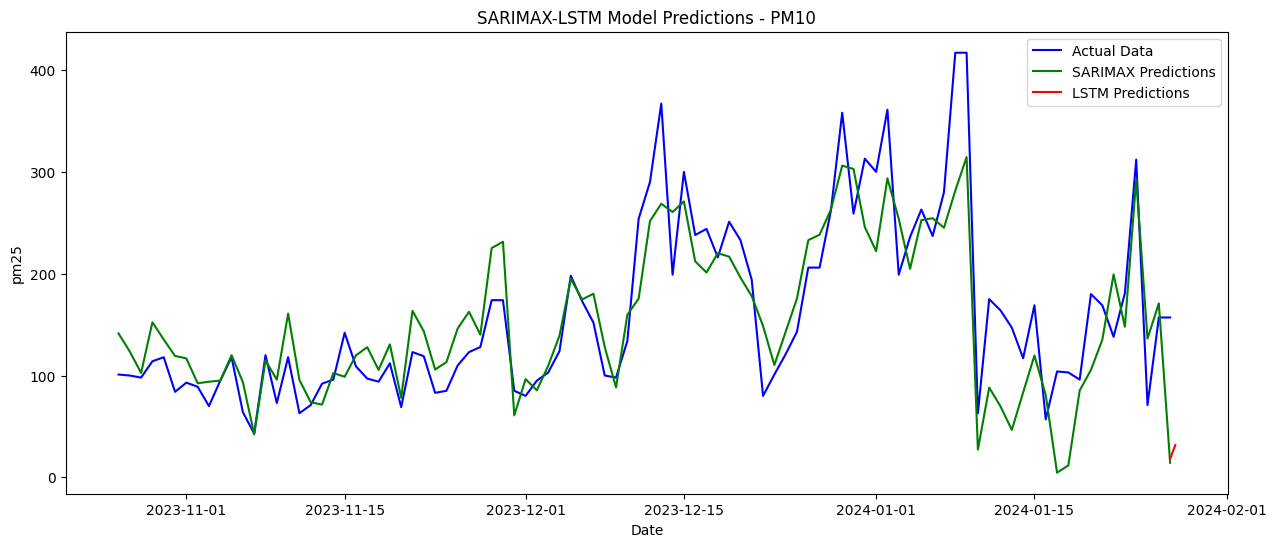

In [28]:
plt.figure(figsize=(15, 6))
#plt.plot(train.index, train[' pm10'], label='Train data', color='blue')
plt.plot(test.index, test[' pm10'], label='Actual Data', color='blue')
plt.plot(sarimax_pred_mean.index, sarimax_pred_mean.values, label='SARIMAX Predictions', color='green')
plt.plot(pd.date_range(start=test.index.max(), periods=future_hours, freq='H'), lstm_preds, label='LSTM Predictions', color='red')
plt.legend()
plt.title('SARIMAX-LSTM Model Predictions - PM10')
plt.xlabel('Date')
plt.ylabel('pm25')
plt.show()

In [39]:
rmse = mean_squared_error(test[' pm10'], sarimax_pred_mean.values)
rmse**0.25

6.852391885719546